<a href="https://colab.research.google.com/github/envirodatascience/final-project-urban-treeam/blob/main/Les_UtilityLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from plotnine import *

In [2]:
%%capture
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/all_trees_58_1712257580.csv"
df=pd.read_csv("/content/all_trees_58_1712257580.csv")
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/Neighborhoods.zip"
! unzip /content/Neighborhoods.zip
nbhds= "/content/New_Haven_CT_Neighborhoods.shp"
nbhds=gpd.read_file(nbhds)
nbhds.rename(columns={'Neighbor_1': 'Neighborhood'}, inplace=True)

In [3]:
df.head()

,Site_ID,Latitude,Longitude,Latin_Name,Common_Name,Condition,DBH,Wire,Grow_Space,Organization,Neighborhood,Planted_Date,Department,Latin_Genus,Common_Genus,Last_Editor,Sites
0,4,41.328957,-72.975426,Vacant Site,Vacant Site,Stump,27.0,Yes,Sidewalk Planting Strip,NaN,Amity,NaN,Street Tree,Vacant Site,Vacant Site,Les Welker,4
1,5,41.265270,-72.892364,Gleditsia triacanthos,Honeylocust,NaN,23.0,No,Sidewalk Tree Pit,NaN,East Shore,NaN,Street Tree,Gleditsia,Honeylocust,Mitch Baron,5
2,6,41.323589,-72.908722,Cornus florida,"Dogwood, Flowering",NaN,18.0,No,Sidewalk Tree Pit,NaN,East Rock,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,6
3,7,41.263393,-72.890724,Cornus kousa,"Dogwood, Kousa",NaN,3.0,No,Sidewalk Tree Pit,NaN,East Shore,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,7
4,8,41.326874,-72.916588,Cornus kousa,"Dogwood, Kousa",NaN,4.0,No,Sidewalk Tree Pit,NaN,Prospect Hill,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,8


Based on prior knowlege of the dataset, I know there are some specific things I want to filter out.

1. There are some vacant sites, which are labeled as such in their latin and common names. These don't represent trees anymore, so I don't want to include them.

2. There are park and greenspace trees included in this dataset. I only want to assess street trees.

3. There is a "last editor" whose name is associated with all the trees that have not been edited since the city and URI started using the Treekeeper software and formally registering the presence of powerlines. I am removing all these records because there is no way to assign them to utility wire presence with any amount of certainty (with my resources and skill set). The exception is for the Fair Haven neighborhood, which was inventoried just prior to the migration of data and does have fairly complete powerline and condition data, so I retain those points.

4. I want to remove small (recently planted) trees because they have not yet had the chance to decline. I did not use the "planted date" to filter because I believe this field is not always properly populated. Instead, I used 2.1 as the cut off, because all trees are input as 2 when they are planted

5. I am removing trees without a recorded condition. This is not common for trees that have been inventoried or maintained, but there are still a few.

In [3]:
dfAll=df
df = df[~df['Common_Name'].str.contains('Vacant Site', case=False)]
df = df[df['Department'].str.contains('Street Tree', case=False)]
df = df[(df['Last_Editor'].str.lower() != 'alex foreman') | (df['Neighborhood'] == "Fair Haven")]
df = df[df['Longitude'] >= -73]
df = df[df['DBH'] >= 2.1]
df.dropna(subset=['Condition'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13437 entries, 6 to 30487
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Site_ID       13437 non-null  int64  
 1   Latitude      13437 non-null  float64
 2   Longitude     13437 non-null  float64
 3   Latin_Name    13437 non-null  object 
 4   Common_Name   13437 non-null  object 
 5   Condition     13437 non-null  object 
 6   DBH           13437 non-null  float64
 7   Wire          13437 non-null  object 
 8   Grow_Space    13437 non-null  object 
 9   Organization  1817 non-null   object 
 10  Neighborhood  13437 non-null  object 
 11  Planted_Date  2033 non-null   object 
 12  Department    13437 non-null  object 
 13  Latin_Genus   13437 non-null  object 
 14  Common_Genus  13437 non-null  object 
 15  Last_Editor   13437 non-null  object 
 16  Sites         13437 non-null  int64  
dtypes: float64(3), int64(2), object(12)
memory usage: 1.8+ MB


This brings the number of sites from 30504 to 16616, a little more than half.

Next, I thought it would be valuble to see the distribution of the remaining trees in New Haven.

In [6]:
nbhds.head()

,OBJECTID,ACRES,Neighborho,Neighbor_1,Shape_area,Shape_len,Shape__Are,Shape__Len,UTC_2016,geometry
0,5,157.59,WOOSTER SQUARE,Wooster Square,6.864538e+06,11664.198825,1.131120e+06,4735.843104,.15,"POLYGON ((-72.91448 41.30891, -72.91443 41.308..."
1,8,202.58,DWIGHT,Dwight,8.824339e+06,15305.198643,1.454318e+06,6212.201826,.19,"POLYGON ((-72.94142 41.31631, -72.94021 41.315..."
2,4,226.58,MILL RIVER,Mill River,9.869794e+06,20202.451032,1.626513e+06,8205.143156,.15,"POLYGON ((-72.90118 41.31661, -72.90208 41.316..."
3,10,237.69,EDGEWOOD,Edgewood,1.035363e+07,14738.643104,1.706680e+06,5985.096078,.34,"POLYGON ((-72.94241 41.31665, -72.94300 41.315..."
4,9,302.08,DOWNTOWN,Downtown,1.315854e+07,16821.576475,2.168458e+06,6828.556824,.17,"POLYGON ((-72.92680 41.31523, -72.92652 41.315..."


In [4]:
from shapely.geometry import Point
nbhds = nbhds.to_crs(epsg=4326)
#assigning geometry points to the selected tree sites based on lat and long values, then creating a gdf to align with neighborhood polygons
df['points_geometry'] = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])],crs=nbhds.crs)
nbhds_with_counts = df.groupby('Neighborhood').size().reset_index(name='selected_trees')
nbhds = nbhds.merge(nbhds_with_counts, on='Neighborhood', how='left')
nbhds = nbhds.merge(dfAll['Neighborhood'].value_counts(), on='Neighborhood', how='left')
nbhds['perc_total'] = (nbhds['selected_trees'] / nbhds['count']) * 100

Notably, wooster square and mill river both have "NA" trees. This is because the original dataset lumps these two neighborhoods together. No inventory has been recently conducted, so there are very few usable datapoints from these two neighborhoods anyway.

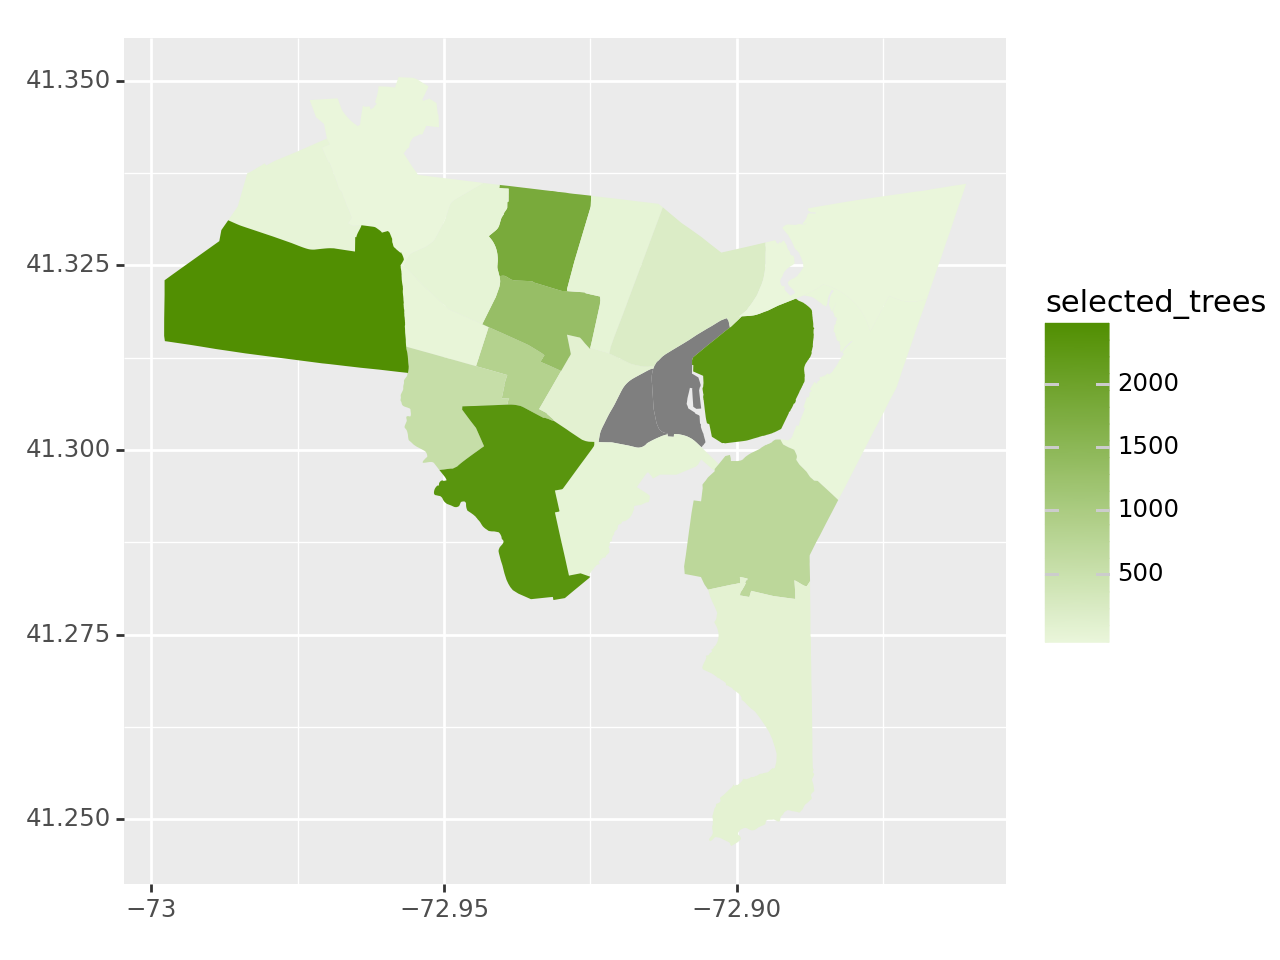

<Figure Size: (640 x 480)>

In [7]:
(
  ggplot()
   + geom_map(nbhds, aes(geometry='geometry', fill="selected_trees"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

The number of trees retained after the data cleaning earlier is just over a third of trees in the city. There are clear hotspots, but we know that tree canopy in general is not evenly distributed in reality, so its possible that the distribution we see here is partially due to that.

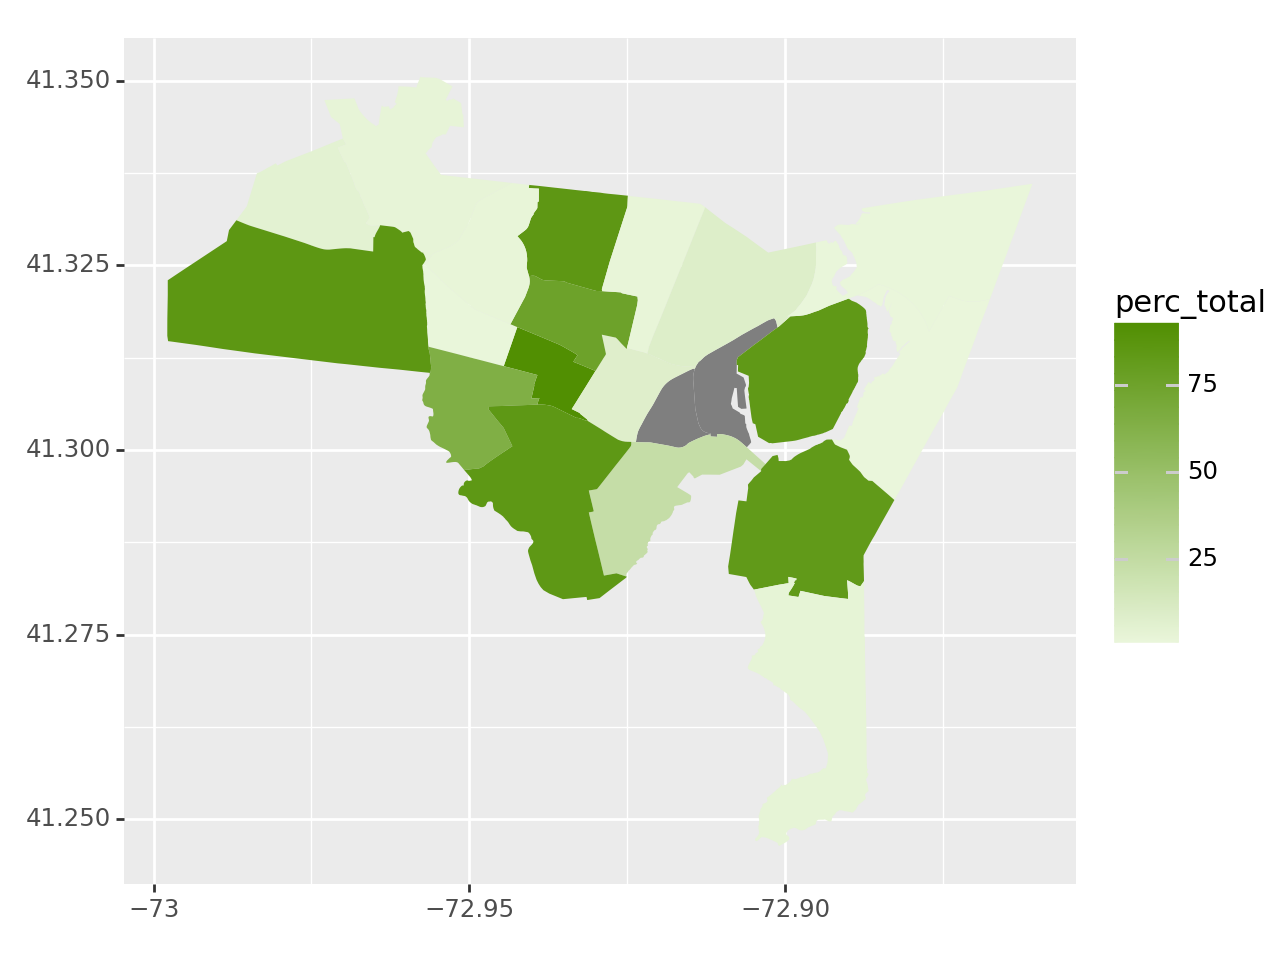

<Figure Size: (640 x 480)>

In [9]:
(
  ggplot()
   + geom_map(nbhds, aes(geometry='geometry', fill="perc_total"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

The second map shows the percent of trees kept, out of all the tree in the original dats set. Most neighborhoods have either most of their trees retained or near none of them retained. This clearly aligns with where URI has been conducting inventories. This map identifies for us which neighborhoods have complete-enough data for this analysis.  I will proceed by retaining only points which belong to neighborhoods with at least 75% of their trees retained. Yes, this number is arbitrary.

In [11]:
nbhds=nbhds[nbhds['perc_total']>75]

# Keep only the rows in df where the value in 'Column_Name' is present in df2
df = df[df['Neighborhood'].isin(nbhds['Neighborhood'].unique())]

Next, I want to set a few different goals.
1. vizualize the percentage of trees under powerlines in each neighborhood
2. calculate the average dbh of trees under powerlines and not under powerlines
3. calculate and vizualize the average health of trees under powerlines and not under powerlines.